# Hands-On Machine Learning

## Session 8: Solving segmentation tasks with Deep Learning
by Oliver Rippel & Leon Weninger

### Goals of this Session

In this session you will...
* learn how to adapt the classifier architecture to solve segmentation tasks
* adapt your own classifier using the knowledge above



### PASCAL VOC Dataset

In this exercise, you will use the PASCAL VOC dataset, which you already know from your last session. It contains 20 classes, and you used it to detect the presence of classes such as "person" or "bird" in your images. Apart from the mere presence of classes, PASCAL VOC also contains information about where exactly in the image the classes are present in the form of segmentation masks. Today, you will learn how to perform segmentations using Deep Learning.

But first, let's take a look at some images + segmentation masks from the dataset. They are loaded using the VOC class dataloader we provide you. 

In [1]:
%matplotlib inline

In [2]:
#Import all important modules
from torchvision.datasets import VOCSegmentation

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import math
import os
import torch.utils.model_zoo as model_zoo
import train
from misc import get_upsampling_weight

First, we define if the network should run on GPU or CPU. On the official tutorial machines, a GPU is available. Remember later on to specify the network to run on "device".

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# dataset path for all datasets
dset_path = os.path.join(os.path.abspath(os.environ["HOME"]), 'datasets')
try:
    voc = VOCSegmentation(root=dset_path, download=False)
except RuntimeError:
    if not os.path.isdir(dset_path):
            os.makedirs(dset_path)
    voc = VOCSegmentation(root=dset_path, download=True)

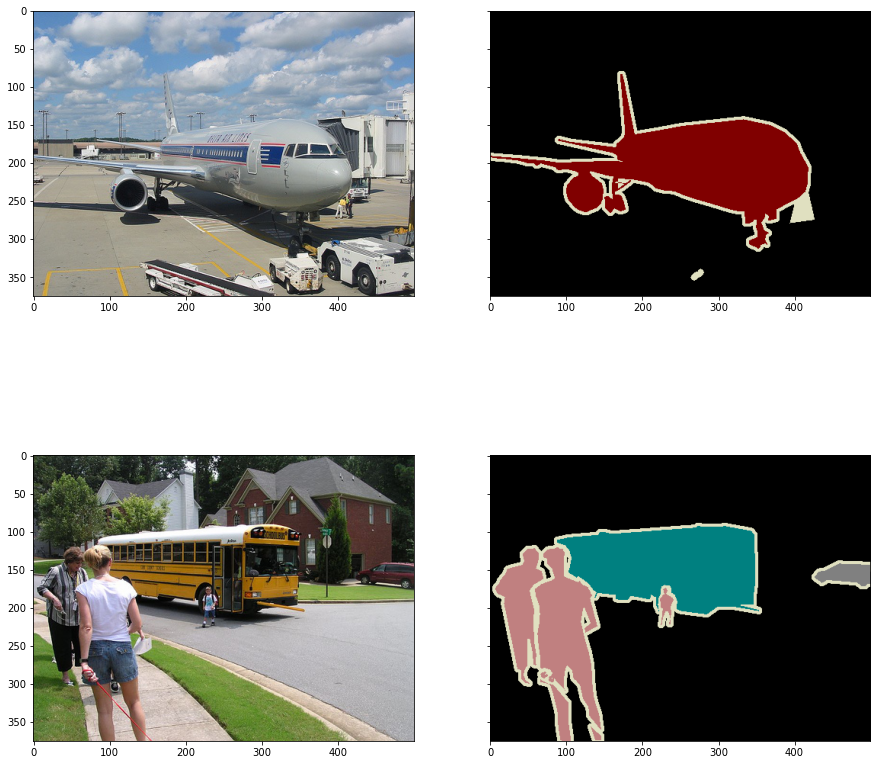

In [5]:
f, ax = plt.subplots(2, 2, sharey=True, figsize=(15,15))
for i in range(2):
    img, mask = voc[np.random.randint(0,1400 + 1)]
    ax[i,0].imshow(img)
    ax[i,1].imshow(mask.convert('RGB'))
plt.show()

### RECAP Deep Learning so far

As we learned in the prior sessions, Deep Learning has shown to be immensely powerful when performing object recognition tasks. Structurally, it consists of the following 3 core components:

1. Model architecture
1. Loss function
1. Optimization method.

**Task:** Which of the 3 components need to be adapted to change a classification model into a segmentation segmentation model? <br/>
**Answer:** Model architecture and the loss function



### Changing the VGG-Net from a classifier to a segmentation model

In the following, we will change the VGG-Net from a classifier to a segmentation model. To do so, you will change the model architecture as well as the loss function accordingly.

![grafik.png](embedded_imges/imagenet_vgg16.png)

So this is how the original VGG-Net looked like. Below, you can see a PyTorch implementation of the above representation.

In [6]:
vgg = torchvision.models.vgg16()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

As you can see, the VGG model provided by torch is nicely split into the operations extracting **features** and those acting as the **classifier**. As we learned in the introductory talk, segmentation models can be thought of as classifying each pixel of the image in parallel. Therefore, it would be nice to maintain the HxW dimension in the classifying operations. <br/>
**Task:** Define a new sequential model that maintains spatial HxW relations for the segmenter. Make sure that output shape = input shape! for your sequential model <br/>
**Hints:** Use Convolutionary layers with appropriate Padding instead of Linear layers. A convolutionary operation with kernel-size 1x1 can serve as a per-pixel classifier.

In [43]:
class Segmenter(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Segmenter, self).__init__()
        
        # extract features from VGG as shown above
        vgg = torchvision.models.vgg16()
        if pretrained:
                vgg.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/vgg16-397923af.pth'))
        features = list(vgg.features.children())
        print(features)
        
        self.features = nn.Sequential(*features)        
        
        self.segmenter = nn.Sequential(
        nn.Conv2d(512, 4096, kernel_size=(1, 1)),
        nn.Conv2d(4096, 4096, kernel_size=(1,1)),
        nn.Conv2d(4096, 21, kernel_size=(1,1))
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.segmenter(x)
        return x
        
        

Let's check the model architecture!

In [44]:
# PASCAL VOC contains 20 classes + 1 ignore label == 21 classes in total
model = Segmenter(num_classes = 21).to(device)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace), Conv2d(512, 512, kern

Let's also check what the model output shape is.

In [45]:
#remember, torch expects tensors of shape NxCxHxW
shape = (1,3,320,320)
print(model.forward(torch.Tensor(np.ones(shape=shape,dtype=np.float32)).to(device)).size())

torch.Size([1, 21, 10, 10])


Our model should now output tensors with HxW = 10 instead of the 1x1 for the classifier (if it doesn't and you fed shape of (1,3,320,320) into the model, check your model definition!). However, the shape is still far too coarse to directly compare to the input segmentation mask. <br/>
**Task:** What parameters determine the output shape in HxW dimension of your model?  Try changing some of your parameters, or even the input shape <br/>
**Answer**:kernel size, stride, number of classes.



If you have played around with the Input shape, you may have seen that an output is generated for any HxW shape, one major advantage of Fully Convolutional Networks (FCNs) compared to those using Fully Connected Layers!
However, while your initial segmenter is capable of generating 2-D output, its output HxW dimension are way smaller than those of the image we fed into it. Therefore, we need to somehow interpolate the original input from this dense map. <br/>
**Task:** How could this be done? <br/>
**Answer**:
By using upsampling through deconvolution or Transposed convolution.


In Deep Learning, a neat operation exists, the Transposed Convolution. In its essence, it pads the input BEFORE performing the normal convolution operation on it. By choosing the padding in between the input(blue), kernel_size and stride accordingly, upscaling can be performed. If desired, the kernel weights are again learnable. Neat!

<img src = 'embedded_imges/padding_strides_transposed.gif'>

**Task** Modify your segmenter by adding Transposed Convolution (nn.ConvTranspose2d) for interpolation so that the output  size matches input size for input of shape (1,3,320,320). <br/>
**Hints**:
1. The output shape of the nn.ConvTranspose2d is given by <br/>
Input: $(N, C_{in}, H_{in}, W_{in})$ <br/>
Output: $(N,C_{out},H_{out},W_{out})$ <br/>
where $H_{out}=(H_{in}−1)∗stride[0]−2∗padding[0]+kernel\_size[0]+output\_padding[0]$  
$W_{out}=(W_{in}−1)∗stride[1]−2∗padding[1]+kernel\_size[1]+output\_padding[1]$ <br/>

2. Dimensionality reduction is only performed by the MaxPool layers. In total dimensionality is reduced by a factor of $2^{5}=32$. Therefore, stride of nn.ConvTranspose2d should be set to 32 so that the spatial distance between the upsampled features is kept the same.

In [53]:
class Segmenter(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Segmenter, self).__init__()
        
        # extract features from VGG as shown above
        vgg = torchvision.models.vgg16()
        if pretrained:
                vgg.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/vgg16-397923af.pth'))
        features= list(vgg.features.children())
        
        self.features = nn.Sequential(*features)        

        self.segmenter = nn.Sequential(
        nn.Conv2d(512, 4096, kernel_size=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(4096, 4096, kernel_size=(1,1)),
        nn.ReLU(),
        nn.Conv2d(4096, 21, kernel_size=(1,1)),
        )
        
        self.upsampling = nn.ConvTranspose2d(21,21, (64,64), stride = (32,32), padding = (16,16))
        self.upsampling.weight.data.copy_(get_upsampling_weight(21,21,64))
                       
        """ 
        as we are short on training time, we need to initialize our interpolator weights to perform linear interpolation
        for a fast convergence.
        Do this using the get_upsampling_weight(no_input features, no_output features, kernel_size) function.
        You can change the weights of a nn.module by calling its .weight.data.copy_() function.
        """
    def forward(self, x):
        x = self.features(x)
        x = self.segmenter(x)
        x = self.upsampling(x)
        return x
    
model = Segmenter(num_classes = 21).to(device)
shape = (1,3,320,320)
print(model.forward(torch.Tensor(np.ones(shape=shape,dtype=np.float32)).to(device)).size())

torch.Size([1, 21, 320, 320])


Our model is now able to learn interpolation from the [1, 21, 10, 10] predicted segmentation to the [1,21,320,320] sized input segmentation!. The next step is to train our model for a little bit and see what the output is. This is done by using the train module we provide you. In this train module, the model is trained with SGD using the specifications below. It does so by iterating over the contents of the VOC dataloader, optimizing the loss given by *nn.CrossEntropyLoss*. After every epoch, it uses the validation set of VOC for validation, printing averages for loss, ACCuracy, mean ACCuracy of all CLaSses, mean Intersection over Union and Frequency Weighted ACCuracy. It furthermore returns validation images that can be displyed for visualization purposes.

In [54]:
args = {
    'epoch_num': 3,
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'momentum': 0.95,
    'lr_patience': 100,  # large patience denotes fixed lr
    'print_freq': 20,
    'val_img_sample_rate': 0.1  # randomly sample some validation results to display
}
imges = train.main(train_args=args, model=model)

{'epoch_num': 3, 'lr': 0.0001, 'weight_decay': 0.0001, 'momentum': 0.95, 'lr_patience': 100, 'print_freq': 20, 'val_img_sample_rate': 0.1}
[epoch 1], [iter 20 / 1464], [train loss 2.91280]
[epoch 1], [iter 40 / 1464], [train loss 2.76089]
[epoch 1], [iter 60 / 1464], [train loss 2.59682]
[epoch 1], [iter 80 / 1464], [train loss 2.49224]
[epoch 1], [iter 100 / 1464], [train loss 2.41725]
[epoch 1], [iter 120 / 1464], [train loss 2.40014]
[epoch 1], [iter 140 / 1464], [train loss 2.32029]
[epoch 1], [iter 160 / 1464], [train loss 2.22372]
[epoch 1], [iter 180 / 1464], [train loss 2.17854]
[epoch 1], [iter 200 / 1464], [train loss 2.14031]
[epoch 1], [iter 220 / 1464], [train loss 2.07724]
[epoch 1], [iter 240 / 1464], [train loss 2.02056]
[epoch 1], [iter 260 / 1464], [train loss 2.01267]
[epoch 1], [iter 280 / 1464], [train loss 1.97407]
[epoch 1], [iter 300 / 1464], [train loss 1.95388]
[epoch 1], [iter 320 / 1464], [train loss 1.91010]
[epoch 1], [iter 340 / 1464], [train loss 1.89948

While the model is training, you are surely asking yourself how the nn.CrossEntropyLoss works. It's based on the Negative-Log Likelihood Loss used for classification, which is defined as follows:


$L = -\sum_{n=1}^My_{n}\log(p_{n})$

Where $M$ are the number of classes, and $y_n$ is equal to 1 for the true class label and 0 otherwise.

**Task:** Modify the NLL Loss from classification to segmentation. <br/>
**Hint:** Remember that segmentation can be understood as pixel-wise classification. <br/>
**Answer:** We have to apply the loss function for all the pixels.



After training has finished, let's look at some images from the validation set! Repeatedly execute the cell below to get several glimpses.

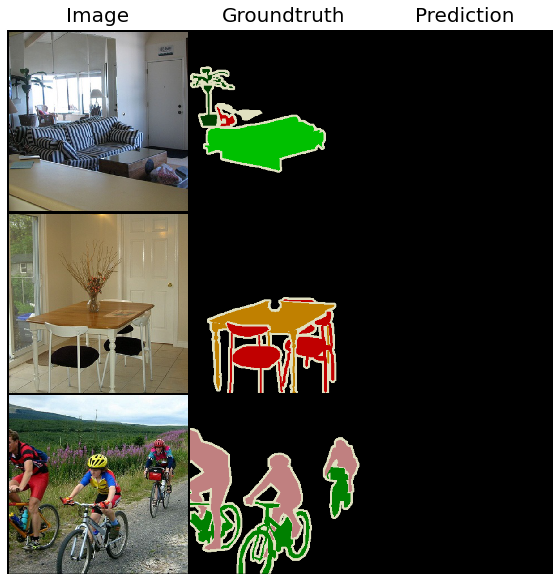

In [50]:
npimg = imges.numpy()
img_size = 405
img_to_show = 3
random = np.random.randint(0,65)
npimg = npimg[:,random*img_size:(random+img_to_show)*img_size, :]
plt.figure(figsize=(10,10))
plt.text(130,-20, 'Image', fontsize = 20)
plt.text(480,-20, 'Groundtruth', fontsize = 20)
plt.text(910,-20, 'Prediction', fontsize = 20)
plt.axis('off')
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')